In [54]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulate data

In [55]:
import prfpy_csenf
import os 
from os.path import join as opj
seq_path = os.path.join(os.path.dirname(prfpy_csenf.__path__[0]))
sfs_seq = np.load(opj(seq_path, 'eg_sfs_seq.npy'))
con_seq = np.load(opj(seq_path, 'eg_con_seq.npy'))
paradigm = np.vstack([sfs_seq, con_seq])


In [56]:
# Stimulus object 
from braincoder.stimuli import ContrastSensitivityStimulus
cs_stim = ContrastSensitivityStimulus()

In [57]:
parameters = pd.DataFrame({
    #                                
    'width_r'           : np.array([   1.28,   1.50,   1.00,   1.00,]), # [CSF parameters]    
    'SFp'               : np.array([   2.50,   1.00,   4.00,   2.00,]), # 
    'CSp'               : np.array([ 166.00, 100.00,  80.00,  40.00,]), # 
    'width_l'           : np.array([   0.68,   0.68,   0.68,   0.68,]), # 
    'crf_exp'           : np.array([   1.50,   1.50,   2.50,   3.00,]), # [CRF parameter]
    'amplitude'         : np.array([   1.00,   1.00,   1.00,   2.00,]), # [fMRI parameters]
    'baseline'          : np.array([   0.00,   0.00,   0.00,   0.00,]), # 
    # 'hrf_1'             : np.array([   1.00,   1.00,   1.00,   1.00,]), # 
    # 'hrf_2'             : np.array([   0.00,   0.00,   0.00,   0.00,]), # 
    }).astype('float32')



In [58]:
from braincoder.models import ContrastSensitivity, ContrastSensitivityWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel

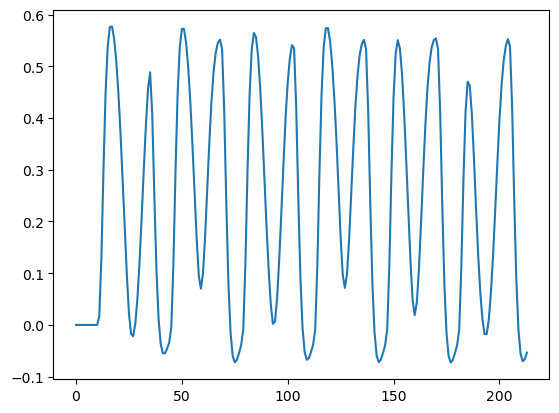

In [59]:
model = ContrastSensitivityWithHRF(
    parameters=parameters,
    SF_seq=sfs_seq,  
    CON_seq=con_seq,       
    hrf_model=SPMHRFModel(tr=1.5),

)
pred = model.predict()
plt.plot(pred.iloc[:,0])

# MCMC - lets explore...

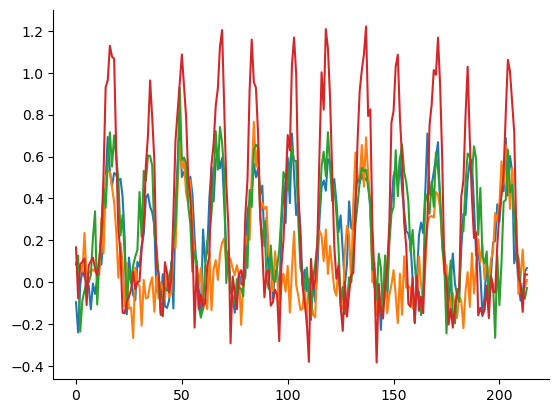

In [60]:

data = model.simulate(noise=.1)
data.plot(legend=False)
sns.despine()
    

In [61]:
from braincoder.bprf_mcmc import *
from braincoder.optimize import ParameterFitter
cfitter = ParameterFitter(model, data, model.paradigm)
grid_pars = cfitter.fit_grid(
    width_r=np.linspace(0, 3, 10),
    SFp=np.linspace(0, 6, 10),
    CSp=np.linspace(50, 200, 10),
    width_l=[0.68],
    crf_exp=np.linspace(1, 3, 10),
    
    baseline=[0.0],
    amplitude=[1.0],
    use_correlation_cost=True
    )
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
ols_pars

Working with chunk size of 778816
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00,  7.87it/s]


,width_r,SFp,CSp,width_l,crf_exp,amplitude,baseline
source,,,,,,,
0,1.333333,2.666667,166.666672,0.68,1.666667,1.000000,0.000000
1,1.333333,0.666667,116.666664,0.68,1.222222,1.000000,0.000000
2,0.666667,2.666667,66.666664,0.68,2.777778,1.000000,0.000000
3,1.000000,2.000000,50.000000,0.68,3.000000,1.716107,0.029052


In [89]:
bounds = {
    'width_r'  : [0,1.5],          
    'SFp'       : [0, 6],
    'CSp'       : [0, 200] ,
    'width_l'   : [0.67, 0.69],     # we fix width_l in our model
    'crf_exp'   : [0, 10] ,
    'amplitude' : [0, 1000],       # Amplitude of TC
    'baseline'  : [-2,2]
}
fitter = BPRF(model, data)
fitter.add_priors_from_bounds(
    bounds, prior_type='latent_uniform'
)

init_pars = {
    'width_r' : np.ones(4) * 1,
    'SFp' : np.ones(4) * 3,
    'CSp' : np.ones(4) * 100,
    'width_l' : np.ones(4) * 0.68,
    'crf_exp' : np.ones(4) * 1,
    'amplitude' : np.ones(4) * 1, 
    'baseline' : np.ones(4) * 0, 
}
init_pars = pd.DataFrame(init_pars)


fitter.fit(
    idx = [1],
    num_results=10000,
    kernel_type='braincoder',
    init_pars=init_pars, 
)

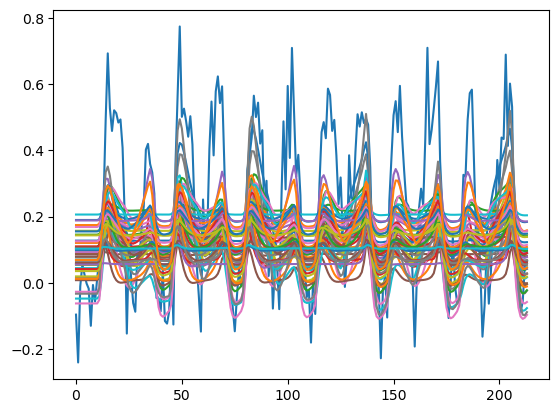

In [92]:
a = fitter.mcmc_sampler[1]
pred = model.predict(parameters=a.loc[9999:,:])

plt.plot(data.iloc[:,0])
plt.plot(pred)

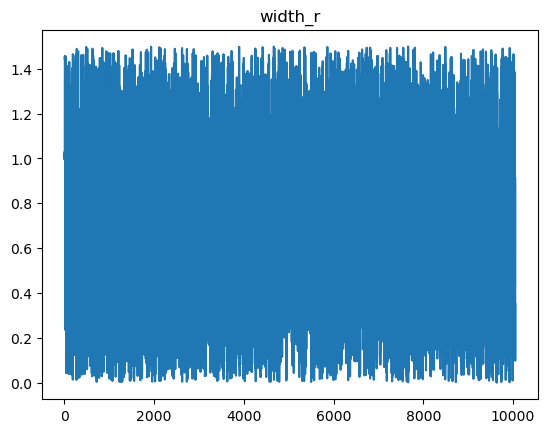

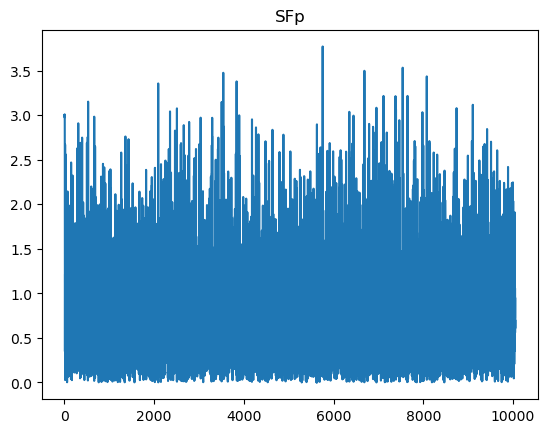

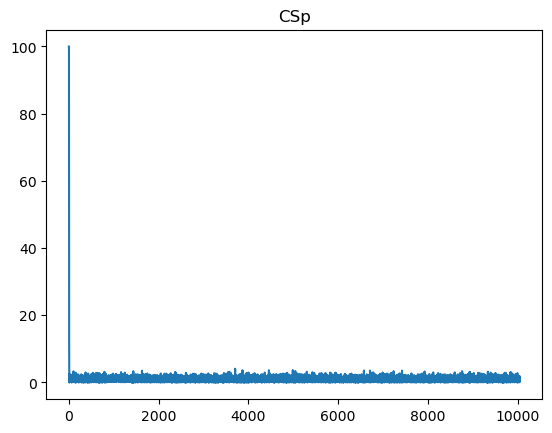

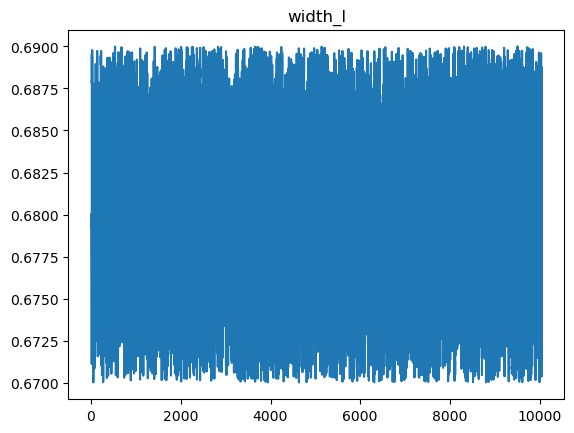

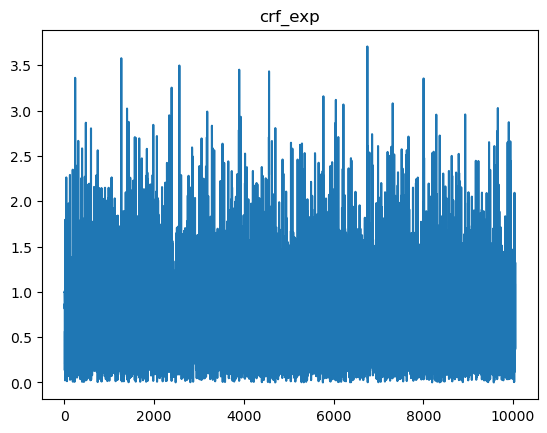

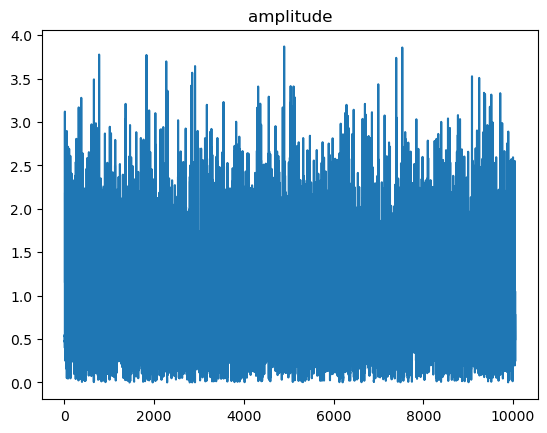

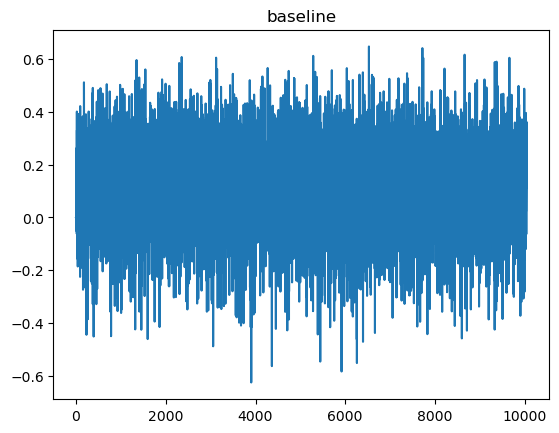

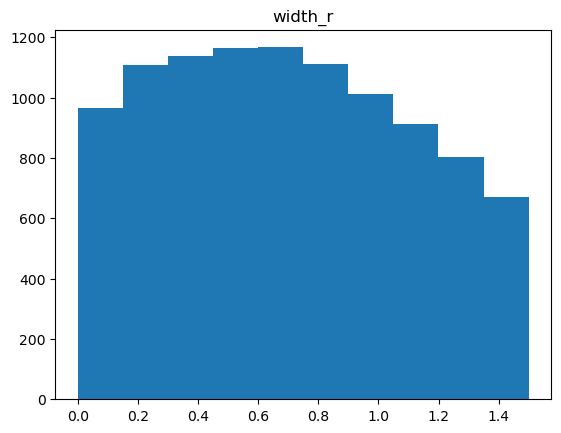

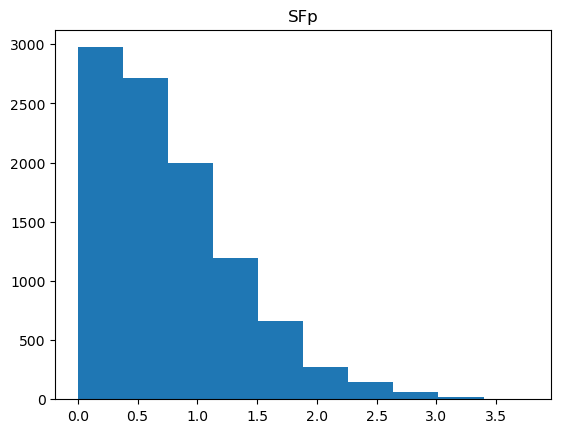

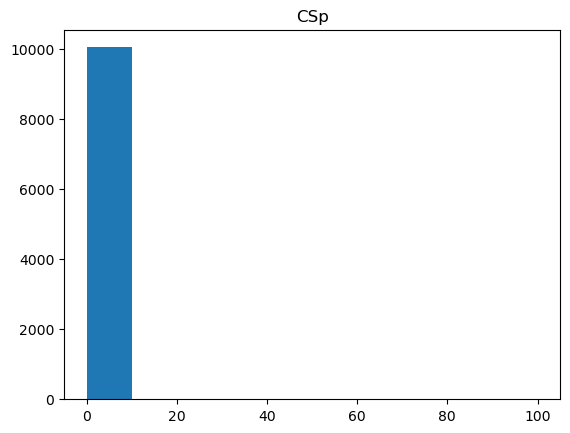

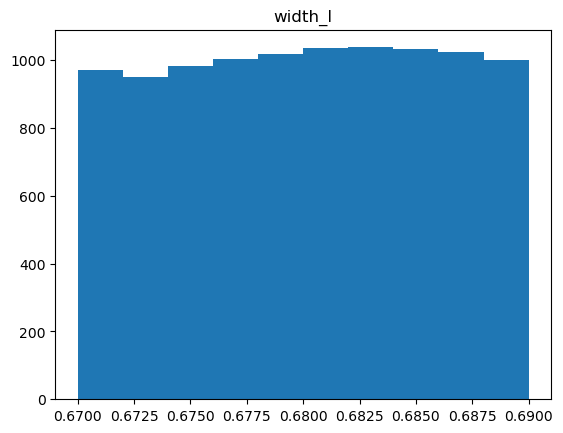

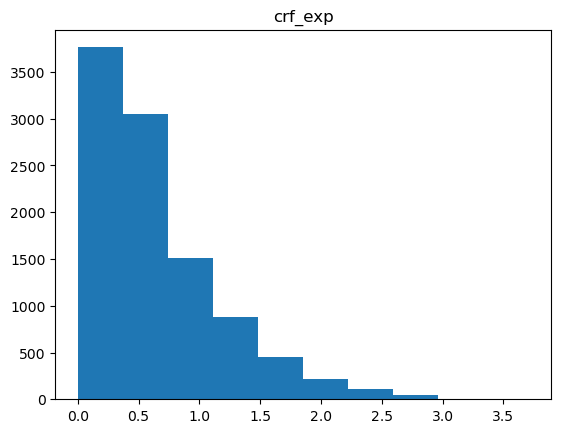

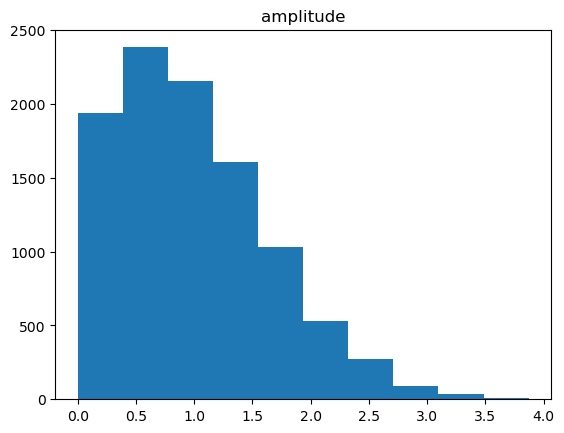

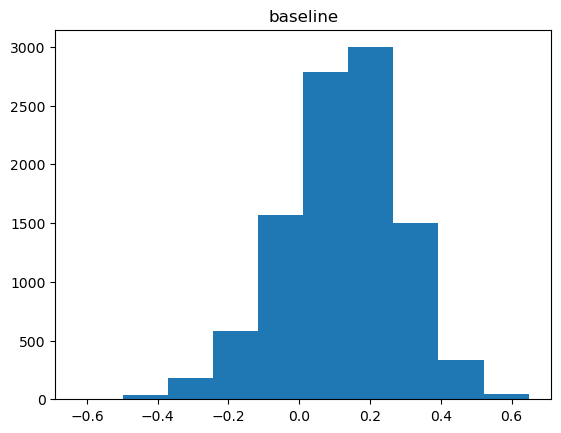

In [93]:
for p in a.keys():
    plt.figure()
    plt.plot(a[p])
    plt.title(p)

for p in a.keys():
    plt.figure()
    plt.hist(a[p])
    plt.title(p)    

In [24]:
fitter.mcmc_sampler[0]

width_r        1.50
SFp            1.00
CSp          100.00
width_l        0.68
crf_exp        1.50
amplitude      1.00
baseline       0.00
Name: 1, dtype: float32


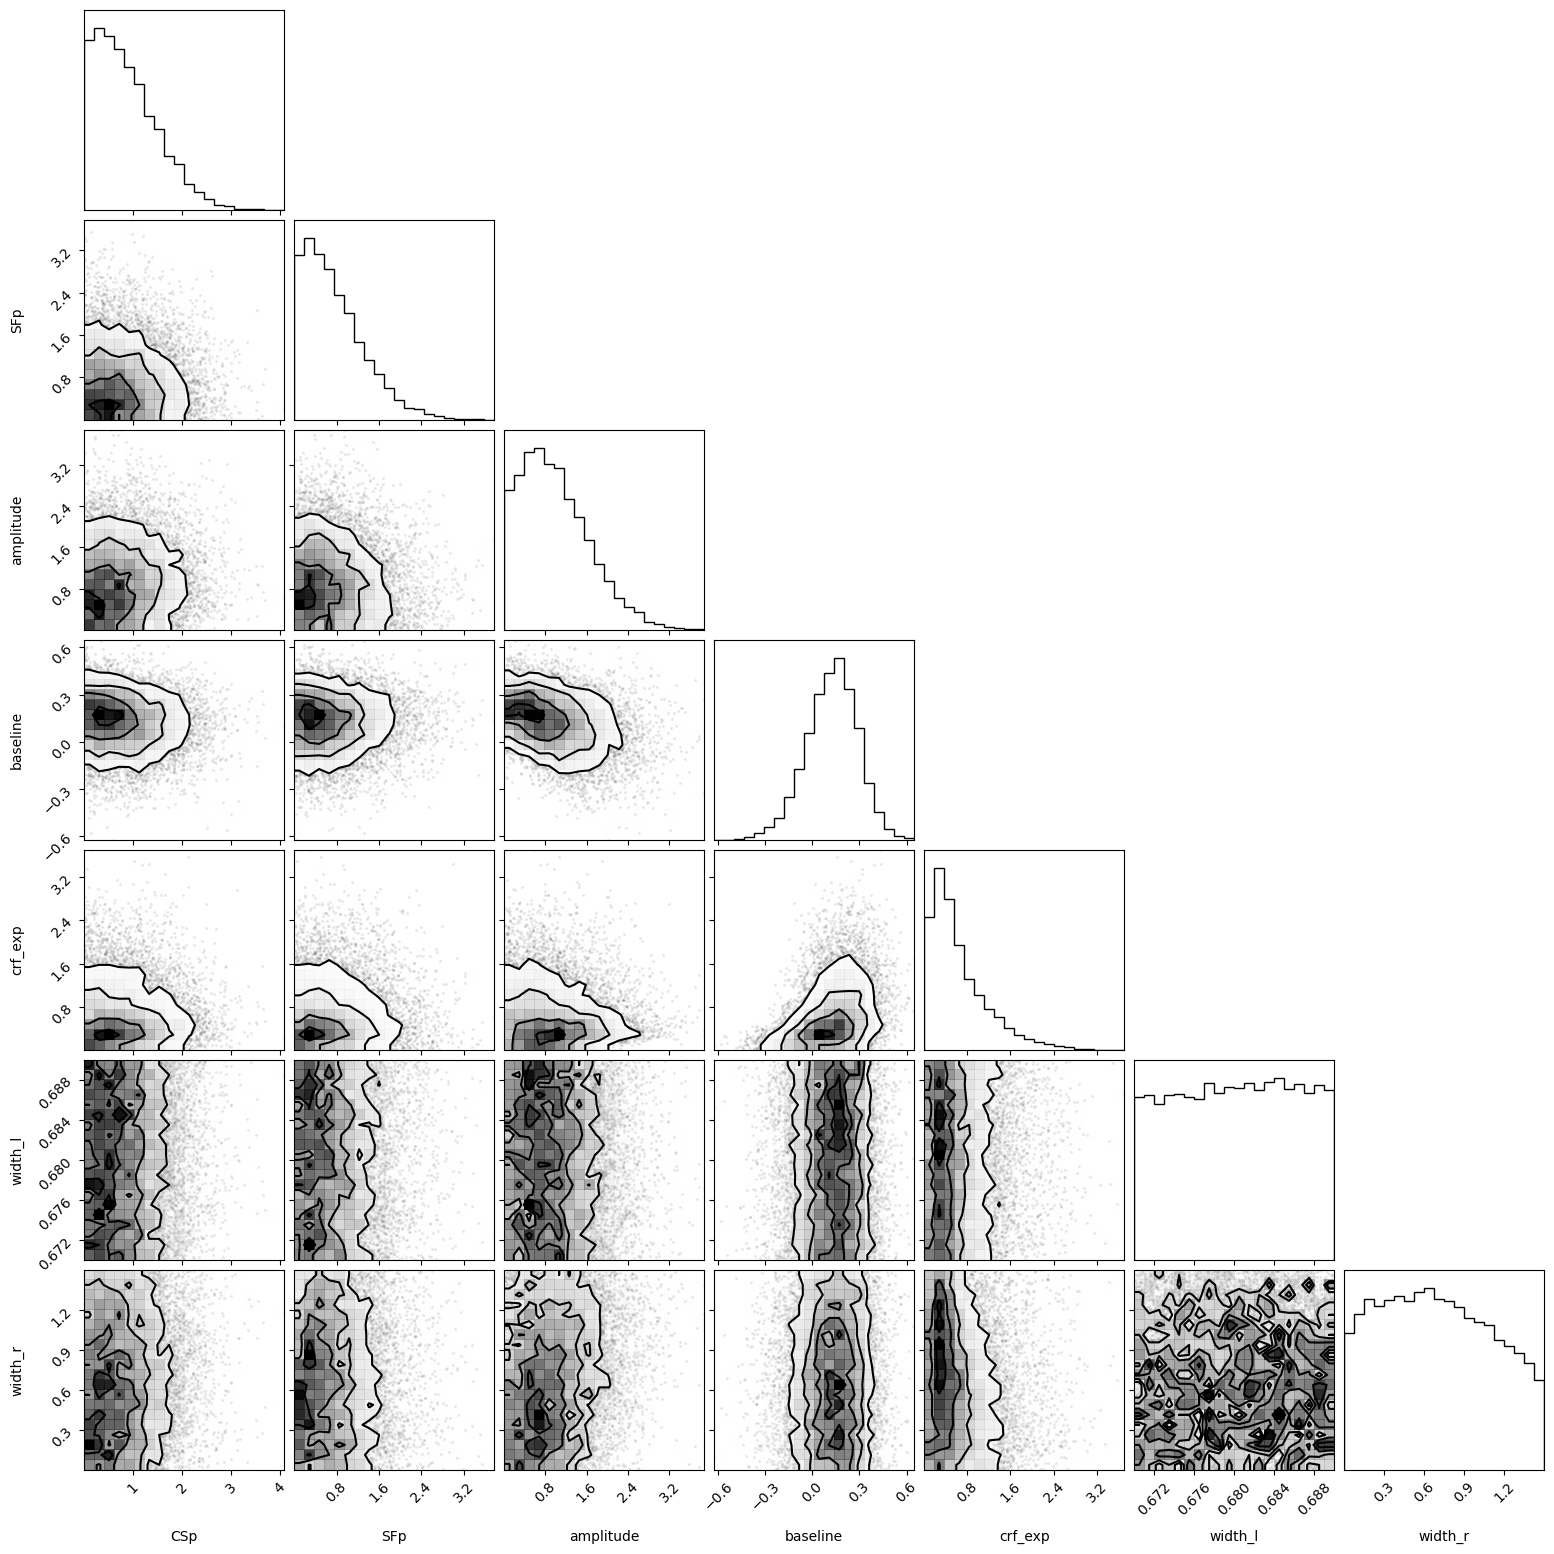

In [94]:
import corner as corner
_ = corner.corner(
    fitter.mcmc_sampler[1].iloc[500:,:],# truths=parameters.iloc[0,:].T
    # truths=parameters.iloc[1,:]
)
print(parameters.iloc[1,:])
# corner.overplot_points(
#     plt.gcf(), parameters.iloc[0,:],
# )

<Axes: >

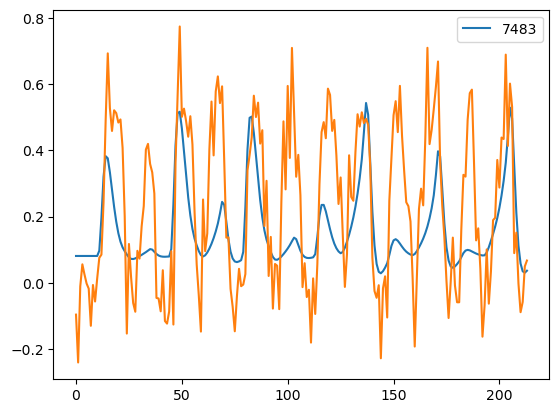

In [105]:
pred = fitter.model.predict(
    parameters=fitter.mcmc_sampler[1].iloc[7483:7484,:]
)
pred.plot()
data.iloc[:,0].plot()

In [104]:
fitter.mcmc_stats[1]['log_prob'].numpy().argmax()

7484

In [ ]:
parameters.keys()
a.keys()

In [ ]:
parameters

In [ ]:
b = model.predict(parameters=a.iloc[:100,:])
plt.plot(b)
plt.plot(data.iloc[:,0], '--k')

In [ ]:
data.iloc[:,0]

In [ ]:
Code

In [ ]:
pars  = ols_pars.iloc[:,0].to_numpy()
pars = pars[np.newaxis,...]
model.predict(parameters = pars) #ols_pars.iloc[:,:0])

In [93]:
eg1 = a[0].numpy()
eg2 = a[1].numpy()

In [ ]:
plt.plot(eg1[:,0])
plt.plot(eg2[:,0])

In [ ]:
init_pars = model._get_parameters(ols_pars)
model._transform_parameters_backward(init_pars.values.astype(np.float32))
